# --> Random Forest (Titanic) <--

In [492]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# *Load, Clean & Preprocess Data*

In [493]:
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [494]:
# sum of missing values for each column
missing_data = df.isna().sum()
missing_data

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [495]:
# using the mean of the Age values to fill in the missing Age values
df['Age'].fillna(df['Age'].mean(), inplace= True)

C:\Users\hpnol\AppData\Local\Temp\ipykernel_15544\2739706538.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].mean(), inplace= True)


In [496]:
# remove unwanted columns
# dropping the PassengerId column as the information is not useful
# dropping the Ticket column as the information is hard to make use of
# dropping the Name column as the information will not help us influence survival rate
# dropping the Cabin column due to missing values
df = df.drop(columns= ['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [497]:
# one-hot encoding to the 'Sex' column
df = pd.get_dummies(df, prefix= "Sex", columns= ["Sex"])

# one-hot encoding to the 'Embarked' column
df = pd.get_dummies(df, prefix= "Embarked", columns= ["Embarked"])

df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


# *Create Random Forest to Predict Survival Chances*

In [498]:
# variables, X = indepedent, y = dependant
# all columns bar from Survived
X = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
         'Embarked_C', 'Embarked_Q', 'Embarked_S']]

# Survived is what we want to work out
y = df['Survived']

In [499]:
# training set
# test_size= 0.2 means 20% in testing set, 80% in training set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42,
                                                     test_size= 0.20)

In [500]:
# classifier
rf = RandomForestClassifier()

In [501]:
# fit the data with training model
rf.fit(X_train, y_train)

RandomForestClassifier()

In [502]:
# prediction of test data
y_pred = rf.predict(X_test)

# *Features that influence passenger survival rate the most*

In [503]:
# how important each feature is & turning it into a DataFrame
column_importance = pd.DataFrame(rf.feature_importances_, index= X.columns)

It's clear from this that Fare had the most significant impact on survival rate, closely followed by Age.

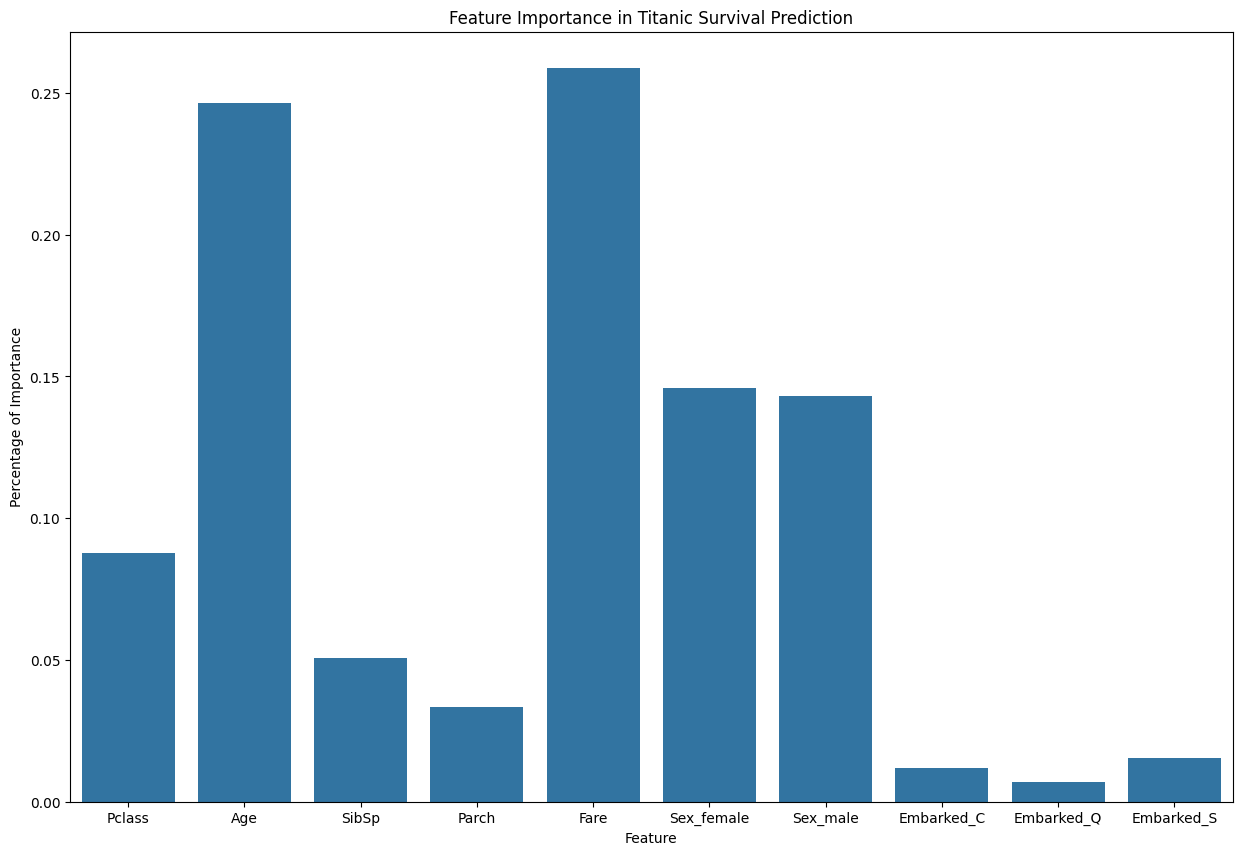

In [504]:
# seaborn bar plot to visualise the importance of a column

# figure size
plt.figure(figsize=(15, 10))

# plotting with seaborn
sns.barplot(x= X.columns, y= rf.feature_importances_, data= column_importance)

# title & labels
plt.title("Feature Importance in Titanic Survival Prediction")
plt.ylabel("Percentage of Importance")
plt.xlabel("Feature")

# show
plt.show()

This barplot supports the above statement about Fare & Age being impactful. It also shows how Sex can be very be a very significant feature to consider when wanting to understanding Survival Rate on the Titanic.

# *Tune the n_estimators and max_depth parameters*

In [505]:
# hyperparameter tuning for random forest using GridSearchCV
# try different numbers of trees
# try different max depths
params = {'n_estimators': [5, 10, 15, 20],
               'max_depth': [2, 4, 6, 8, 10]}

In [506]:
# instantiate the grid search model
# GridSearchCV to perform cross-validation and search through the parameter grid.
grid_search = GridSearchCV(estimator= rf, param_grid= params, cv= 4,
                            n_jobs= -1, verbose= 1, scoring= 'accuracy')

In [507]:
# fit the grid search to the training set
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [5, 10, 15, 20]},
             scoring='accuracy', verbose=1)

# *Report the accuracy of all models and report which model performed the best*

In [508]:
# reporting the accuracy of all models

# results from the grid search
results_df = pd.DataFrame(grid_search.cv_results_)

# extract relevant columns (n_estimators, max_depth, mean_test_score)
results_summary_df = results_df[['param_n_estimators', 'param_max_depth',
                               'mean_test_score']]

# sort results by mean_test_score accuracy
results_summary_df = results_summary_df.sort_values(by= 'mean_test_score',
                                               ascending=False)

# display the accuracy of all models
print("Accuracy of all models:")
print(results_summary_df)

Accuracy of all models:
    param_n_estimators  param_max_depth  mean_test_score
10                  15                6         0.827247
6                   15                4         0.820225
5                   10                4         0.820225
8                    5                6         0.818820
4                    5                4         0.818820
9                   10                6         0.818820
11                  20                6         0.817416
15                  20                8         0.816011
7                   20                4         0.816011
13                  10                8         0.814607
12                   5                8         0.814607
18                  15               10         0.813202
14                  15                8         0.811798
19                  20               10         0.808989
0                    5                2         0.806180
17                  10               10         0.803371
16     

In [509]:
# best performing model

# best parameters (can also use .best_params_)
best_estimator = grid_search.best_estimator_
# best accuracy score
best_score = grid_search.best_score_

# print
print("The Best Performing Model")
print(f"Performing Parameters: {best_estimator}")
print(f"Accuracy Score: {best_score}")

The Best Performing Model
Performing Parameters: RandomForestClassifier(max_depth=6, n_estimators=15)
Accuracy Score: 0.827247191011236
